# How does the performance of a distributional model change as we train in on more and more labelled data?

 - Pennington el al (2014) report `word2vec`'s performance at the word analogy task and a range of word similarity task improves with more data. 
 - My own experiments (in `euroscipy_demo` notebook) show performance at the analogy task roughly scales like $log(x)$

Let's investigate if the same holds for the document classification task. For simiplicity, we only look at `word2vec` vectors with simple composion on the Reuters data set.

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
import os
from collections import ChainMap
from gui.models import Experiment
from gui.output_utils import *

import logging, imp
imp.reload(logging)
logging.basicConfig(level=logging.INFO, format="%(levelname)s:\t%(message)s")
logging.info('test')

INFO:	test


/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [30]:
from operator import attrgetter

shared = {'use_similarity': 0, 
          'neighbour_strategy':'linear',
          'vectors__dimensionality': 100, 
          'document_features_ev': 'AN+NN', 
          'document_features_tr': 'J+N+AN+NN', 
          'allow_overlap': False,
          'entries_of': None,
#           'vectors__unlabelled_percentage__in': [70,80], # todo remove this
          'vectors__algorithm': 'word2vec',
          'vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
          'vectors__unlabelled': 'wiki',
          'decode_handler': 'SignifiedOnlyFeatureHandler',
          'noise': 0}

def query_to_ids(ids):
    experiments = Experiment.objects.filter(id__in=ids)
    return sorted(list(set(foo.id for foo in experiments)))

def get_exp_ids_for_varying_k(corpus='amazon_grouped-tagged'):
    # curve when varying k
    query_dict = ChainMap(shared,
                          {'vectors__rep': 0, 
                          'vectors__unlabelled_percentage': 100,
                          'labelled':corpus})
    return query_to_ids(Experiment.objects.filter(**query_dict))

def get_exp_ids_for_varying_amounts_of_unlabelled(corpus='reuters21578/r8-tagged-grouped'):
    query_dict = ChainMap(shared, {'vectors__rep': 0, 
                                  'k':3,
                                  'labelled':corpus})
    return query_to_ids(Experiment.objects.filter(**query_dict))

def get_exp_ids_for_reruns_of_word2vec(corpus='amazon_grouped-tagged'):
    query_dict = ChainMap(shared, {'use_similarity': 0, 
                                  'k':3,
                                  'vectors__unlabelled_percentage': 50,
                                  'labelled':corpus})
    return query_to_ids(Experiment.objects.filter(**query_dict))

# `word2vec` learning curve on Gigaword

INFO:	Algorithm random_vect, id 2, score 0.19451 +- -1.00


48 ids in total: [55, 56, 57, 58, 75, 76, 77, 78, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


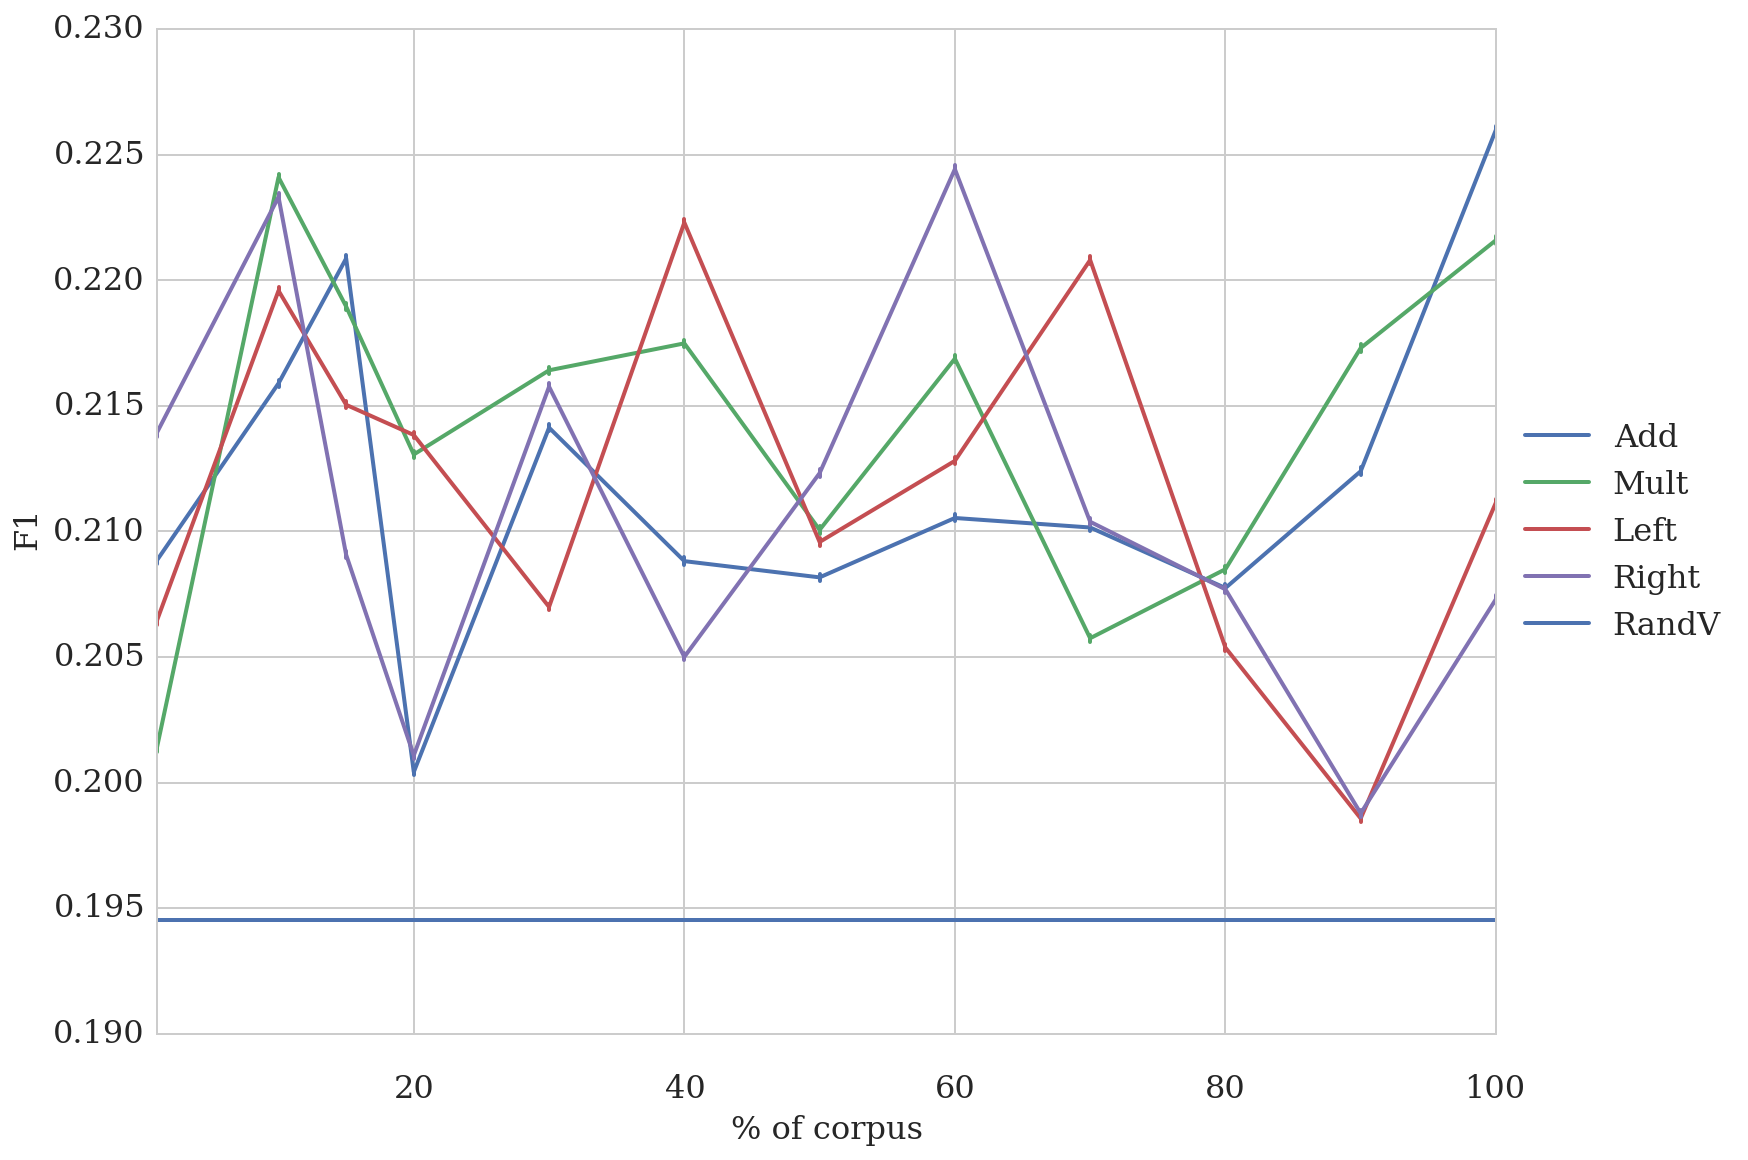

In [14]:
from itertools import chain
# plt.rcParams['lines.linewidth'] = 8
# plt.rcParams['legend.fontsize'] = 40

# corpus = 'reuters21578/r8-tagged-grouped'
corpus = 'amazon_grouped-tagged'

ids = get_exp_ids_for_varying_amounts_of_unlabelled(corpus=corpus)
print(len(ids), 'ids in total:', ids)
scores, folds = get_cv_scores_many_experiment(ids)


cv_folds = get_cv_fold_count(ids)
names = []
for id in ids:
    exp = Experiment.objects.get(id=id)
#     names.append('%s-%s'%(exp.vectors.algorithm, exp.vectors.composer))
    names.append('%s'%(exp.vectors.composer))
names = np.repeat(names, cv_folds)
exp_ids = np.repeat(ids, cv_folds)

df = pd.DataFrame({'F1':scores, 
                   'Composer':names,
                   'cvfold':folds,
                   '% of corpus':get_vectors_field(ids, 'unlabelled_percentage'),
                   'ids':exp_ids})
# df1#['% of Gigaword']
df.to_html('df.html')
df[df.cvfold==0].sort('% of corpus').to_html('dfsmall.html')
    
ax = sns.tsplot(df, time='% of corpus', condition='Composer', value='F1', unit='cvfold',
                err_style=['ci_bars']);
# _ = ax.set_title('Performance vs Amount of unlabelled data');
# _ = ax.set(ylim=(.5, .8)) 
# _ = ax.set(xlim=(None, 10)) # zoom in on the left hand size
# remove axis labels  
# ax.set(xlabel='', ylabel='')

# random baseline
for alg, paper_name in zip(['random_vect', ], ['RandV', ]): # 'random_neigh', 'RandN'
    try: # I don't have random vect results for amazon
        rand = Experiment.objects.get(vectors__algorithm=alg, labelled=corpus).id
        score, score_std = Results.objects.get(id=rand, 
                                                  classifier='MultinomialNB').get_performance_info('macrof1')
        logging.info('Algorithm %s, id %d, score %0.5f +- %0.2f', alg, rand, score, score_std)
        ax.plot(range(0,101), [score]*101, label=paper_name);
    except Exception as e:
        print(e)
        logging.info('Missing %s for %s', alg, corpus)
        continue
plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
plt.savefig('plot-w2v_learning_curve_amazon.pdf' ,format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

 - some variation introduced by classification task
   - each run has a different vocabulary
   - different set of candidate neighbours that can be inserted at decode time

INFO:	Algorithm random_vect, id 2, score 0.19451 +- -1.00


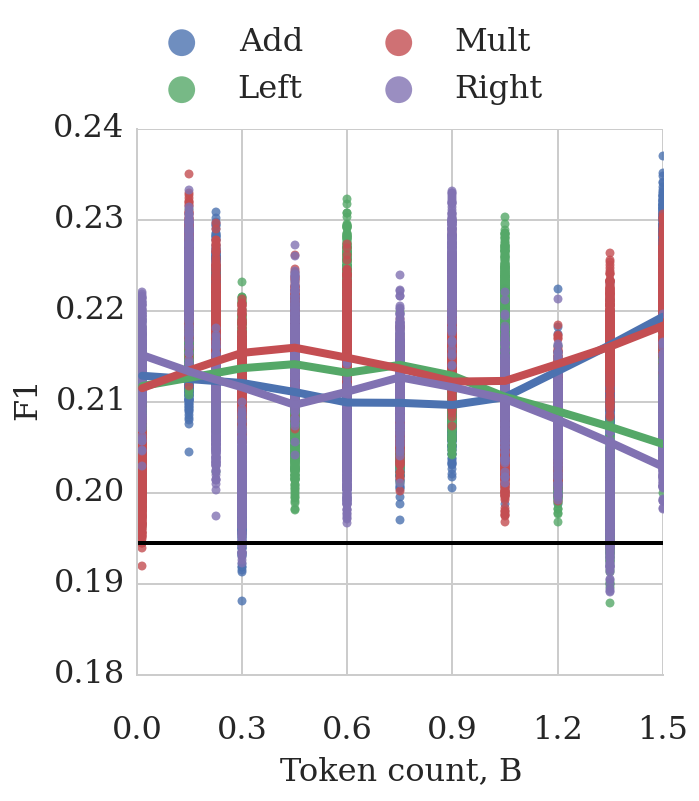

In [15]:
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.labelsize'] = 16

# do main plot
df['Algorithm'] = df.Composer
g = sns.lmplot('% of corpus', 'F1', df, hue='Algorithm', lowess=True, 
               line_kws={"linewidth": 4}, # line size
               legend=False, # hide legend for now, I'll show it later
               aspect=1);

labels = np.arange(0, 101, 20) * 0.01 * 1.5 # convert percent of corpus to a rough token count
g.set(xlim=(0,100), xticklabels=labels, xlabel='Token count, B')


# add random baseline
rand = Experiment.objects.get(vectors__algorithm='random_vect', labelled=corpus).id
score, score_std = Results.objects.get(id=rand, classifier='MultinomialNB').get_performance_info('macrof1')
logging.info('Algorithm %s, id %d, score %0.5f +- %0.2f', alg, rand, score, score_std)
plt.plot(range(0,101), [score]*101, color='k'); # label=paper_name, 

# add a legend with extra bits and bobs
plt.legend(markerscale=3,
           bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3,
           ncol=2,
           borderaxespad=0.)
g.savefig('plot-w2v_learning_curve_amazon2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Variation due to `word2vec`'s random initialisation

 - fairly small at the word analogy task

[70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 85, 86, 87, 88]


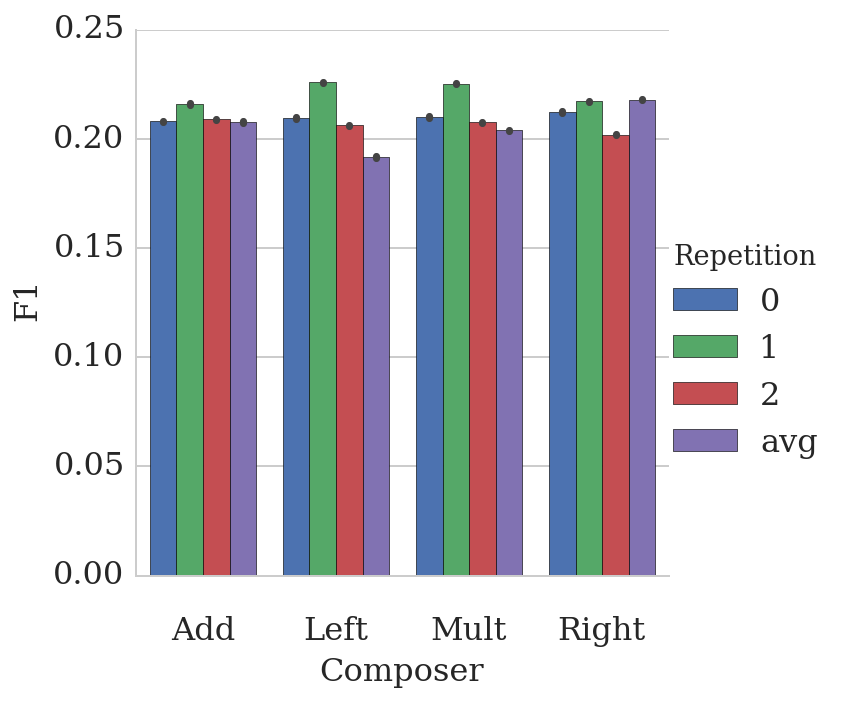

In [16]:
ids = get_exp_ids_for_reruns_of_word2vec() # todo change corpus here
print(ids)
data, folds = get_cv_scores_many_experiment(ids)

reps = [str(x) if x >= 0 else 'avg' for x in get_vectors_field(ids, 'rep')]
df = pd.DataFrame({'F1': data,
                   'Composer': get_vectors_field(ids, 'composer'),
                   'cvfold': folds,
                   'Repetition': reps})
df.to_html('tmp.html')
grid = sns.factorplot(x='Composer', y='F1', hue='Repetition', 
                      data=df, kind='bar');
# grid.set(ylim=(.6, .8));
plt.savefig('plot-w2v_random_init_var.pdf', format='pdf', dpi=300)

 - word embeddings are reasonably stable
 - the lines above for Left and Right are (mostly) flat
     - TODO look deeper into this
 - Composition, esp. multiplication, can result in very different phrase vectors

# Wikipedia vs Gigaword vectors
wiki 15 = giga 100, and for comparison we've got wiki 50

[55, 56, 57, 58]
[29, 30, 31, 32, 40, 41, 42, 43, 45, 46, 47, 48, 114, 124, 134, 144, 174, 176, 178, 180, 184, 187, 190, 193, 196, 199, 202, 205, 223, 249]
[24, 25, 26, 27, 164, 165, 166, 167, 169, 170, 171, 172]
23000 23000 46


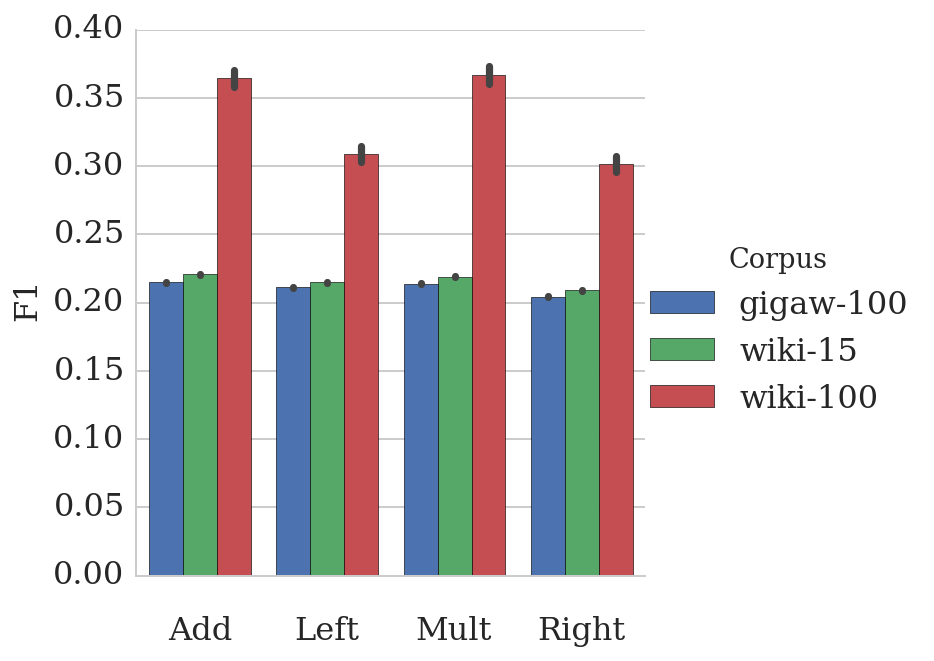

In [33]:
# %pdb
from IPython.core.debugger import Tracer

exp_ids, scores, folds = [], [], []
d1 = {'vectors__unlabelled_percentage': 15, 
     'vectors__unlabelled': 'wiki',
     'vectors__rep':0,
     'document_features_tr':'J+N+AN+NN',
     'document_features_ev':'AN+NN',}
d2 = {'vectors__unlabelled_percentage': 100, 
     'vectors__unlabelled': 'wiki',
     'noise': 0,
     'vectors__algorithm': 'word2vec'}
d3 = {'vectors__unlabelled_percentage': 100, 
     'vectors__unlabelled': 'gigaw',
     'use_similarity': 0, 
      'neighbour_strategy':'linear',
      'vectors__dimensionality': 100, 
      'document_features_ev': 'AN+NN', 
      'vectors__algorithm': 'word2vec',
      'vectors__rep': 0,
      'k':3,
      'labelled':'amazon_grouped-tagged',
      'decode_handler': 'SignifiedOnlyFeatureHandler'}

for d in [d1, d2, d3]:
    ids = query_to_ids(Experiment.objects.filter(**d).\
                       exclude(vectors__composer__in=['Verb', 'CopyObj']))
    print(ids)
    tmp_scores, tmp_folds = get_cv_scores_many_experiment(ids)
    exp_ids.extend(ids)
    scores.extend(tmp_scores)
    folds.extend(tmp_folds)

cv_folds = get_cv_fold_count(exp_ids)
names = []
for id in exp_ids:
    exp = Experiment.objects.get(id=id)
    names.append('%s-%d'%(exp.vectors.unlabelled, exp.vectors.unlabelled_percentage))
names = np.repeat(names, cv_folds)
composers = get_vectors_field(exp_ids, 'composer')


print(len(names), len(scores), len(cv_folds))

df = pd.DataFrame({'F1': scores,
                   'cvfold': folds,
                   'Corpus': names,
                   'Composer': composers})

plt.rcParams['lines.linewidth'] = 2
df[df.cvfold==0].to_html('tmp.html')
order = ['gigaw-100', 'wiki-15', 'wiki-100']
grid = sns.factorplot(hue='Corpus', y='F1', data=df, x='Composer',
                      kind='bar', sharey=True, hue_order=order);
# sns.boxplot(df.F1, df.Corpus)
grid.axes[0][0].set(xlabel='')
plt.savefig('plot-wiki-vs-gigaw.pdf', format='pdf', dpi=300)

# Effect of k parameter

[40, 41, 42, 43, 45, 46, 47, 48, 114, 124, 134, 144]


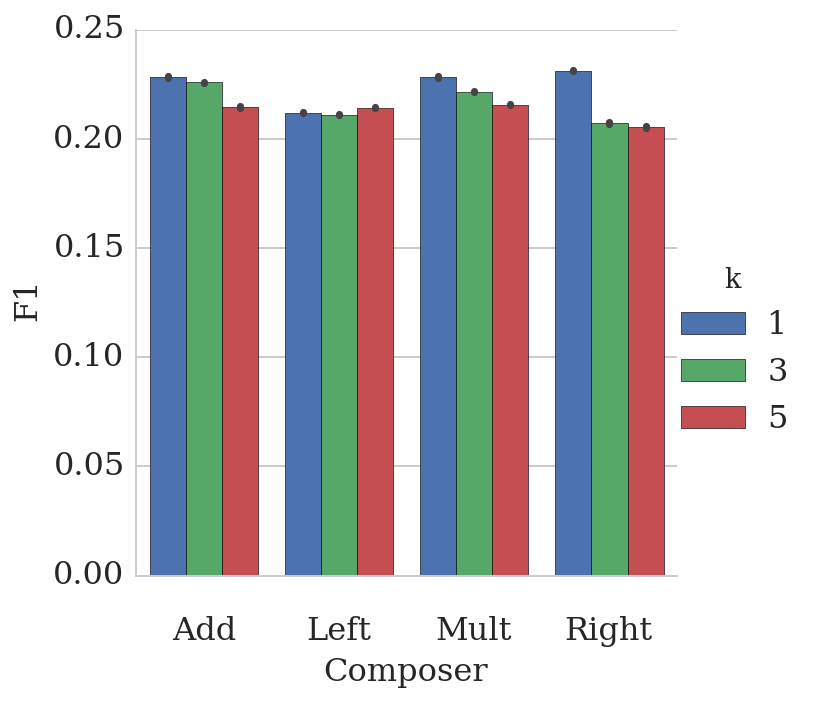

In [31]:
ids = get_exp_ids_for_varying_k()
print(ids)
scores, folds = get_cv_scores_many_experiment(ids)
ks = np.repeat([Experiment.objects.get(id=foo).k for foo in ids],
               get_cv_fold_count(ids))
df = pd.DataFrame({'F1': scores,
                   'k': ks,
                   'cvfold': folds,
                   'Composer': get_vectors_field(ids, 'composer')})
grid = sns.factorplot(hue='k', y='F1', data=df, x='Composer',
                      kind='bar');
plt.savefig('plot-w2v_effect-of-k.pdf', format='pdf', dpi=300)

# Effect of neighbour selection strategy- linear vs skipping

In [32]:
d = {'vectors__dimensionality__in': ['100'], 
     'neighbour_strategy__in': ['linear', 'skipping'], 
     'labelled__in': ['reuters21578/r8-tagged-grouped'],
     'vectors__algorithm__in': ['word2vec'],
     'vectors__unlabelled_percentage__in': ['100.0'], 
     'vectors__unlabelled__in': ['gigaw'], 
     'document_features__in': ['AN_NN'], 
     'vectors__rep__in': ['0'],
     'decode_handler__in': ['SignifiedOnlyFeatureHandler'], 
     'k__in': ['3'], 'use_similarity__in': ['0']}
exp_ids = Experiment.objects.values_list('id', flat=True).filter(**d)
scores, folds = get_cv_scores_many_experiment(exp_ids)
assert ids # we succeeded in getting results

strats = np.repeat([Experiment.objects.get(id=foo).neighbour_strategy for foo in ids],
                   get_cv_fold_count(ids))
df = pd.DataFrame({'F1': scores,
                   'strategy': strats,
                   'cvfold': folds,
                   'Composer': get_vectors_field(ids, 'composer')})
grid = sns.factorplot(hue='strategy', y='F1', data=df, x='Composer',
                      kind='box', sharey=True);
plt.savefig('plot-w2v_linear-vs-skipping-neigh.pdf' ,format='pdf', dpi=300)

ValueError: invalid literal for int() with base 10: '100.0'

# Notes on code below
In earlier iterations of this experiment we used Reuters data, where there was large variation between accuracies of multiple runs of the `word2vec`. The code below looks into why that might be the case. These differences no longer exist, so the code below is probably useless.

# Why is multiply so unstable?
Things to look at
- <s>compare vectors between multiple runs (before and after composition)</s>. The space is completely different, this makes no sense.
 - compare neighbours of a sample of entries between runs
  - without any constraints, out of the full vocabulary
  - out of the neighbours present in the labelled data set
      - redoing experiments [218, 313, 314] and [225, 315, 316] with stats enabled. These are word2vec repeated runs at 100% of gigaw with Add/Mult composer respectively
  
- Could the whole variation be simply down to the small size of Reuters? Would using Amazon help? 
  - in general error bounds due to classification task are much smaller on Amazon (~1%) as apposed to ~3-4% on Reuters

- Performance of `w2v` models I've trained on google's analogy task
    - can't easily calculate as I have stemmed and added a pos tar => syntactic part of test is impossible to do
    - compute something like Precision@K/MAP instead of accuracy of top neighbour

In [6]:
# Compare unigram vectors between multiple runs
from glob import glob
from discoutils.thesaurus_loader import Vectors as V
pattern = '/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-100perc.unigr.strings.rep*'
# pattern = '/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep*'
files = sorted(glob(pattern))
thes = [V.from_tsv(f) for f in files]

INFO:	Loading thesaurus /mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-100perc.unigr.strings.rep0 from disk
INFO:	Loading thesaurus /mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-100perc.unigr.strings.rep1 from disk
INFO:	Loading thesaurus /mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-100perc.unigr.strings.rep2 from disk


In [7]:
# all 3 runs should contain the same entries
assert all(x.keys() == thes[0].keys() for x in thes)
assert all(len(x) == len(thes[0]) for x in thes)

from scipy.spatial.distance import cosine, euclidean
from itertools import combinations
from random import sample

pairs = []
sims = []
s = sample([x for x in thes[0].keys() if x[-1] in 'NJ'], 500)
for i,j in combinations(range(len(thes)), 2):
    print('Doing pair %d and %d'%(i,j))
    d = [euclidean(thes[i].get_vector(foo).A, 
                   thes[j].get_vector(foo).A) for foo in s] # cosine distance
    sims.extend(d)
    pairs.extend(['%d-%d'%(i,j)]*(len(sims) - len(pairs)))

Doing pair 0 and 1
Doing pair 0 and 2
Doing pair 1 and 2


# Overlap of neighbours for $word_i$ across `word2vec` runs
Dice coefficient over a small sample, neighbours selected out of the entire `word2vec` vocabulary

In [8]:
def dice(n1, n2):
    return 2 * len(set(n1) & set(n2))/ (len(n1) + len(n2))

for t in thes:
    t.init_sims()
pairs = []
sims = []
s = sample([x for x in thes[0].keys() if x[-1] in 'NJ'], 500)
for i,j in combinations(range(len(thes)), 2):
    print('Doing pair %d and %d'%(i,j))
    for num, foo in enumerate(s):
        n1 = [x[0] for x in thes[i].get_nearest_neighbours(foo)[:10]]
        n2 = [x[0] for x in thes[j].get_nearest_neighbours(foo)[:10]]
        sims.append(dice(n1, n2))
    pairs.extend(['%d-%d'%(i,j)]*(len(sims) - len(pairs)))

Doing pair 0 and 1
Doing pair 0 and 2
Doing pair 1 and 2


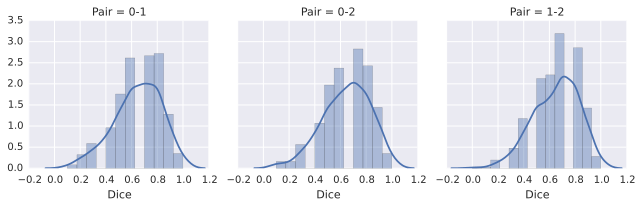

In [9]:
df3 = pd.DataFrame({'Pair': pairs,
                   'Dice': sims,
                   'Words' : s * 3})
g = sns.FacetGrid(df3, col="Pair");
g.map(sns.distplot, 'Dice');

 - Neighbour do not overlap much (not to mention their order)
 - Should I report averaged performance across all runs of `word2vec`?
 
If the neighbours vary so much, why is the performance of some composers so stable? 
  - Do some composers "magnify" differences in input vectors?
  - Is it a matter of vocabulary coverage? the neighbours that we find here are different to the one the classifier finds

# Neighbours selected from ones in vocabulary (fold 0)

/Volumes/LocalDataHD/mmb28/anaconda/envs/py33/lib/python3.3/site-packages/matplotlib/__init__.py:1156: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Volumes/LocalDataHD/mmb28/anaconda/envs/py33/lib/python3.3/site-packages/pandas/io/parsers.py:635: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


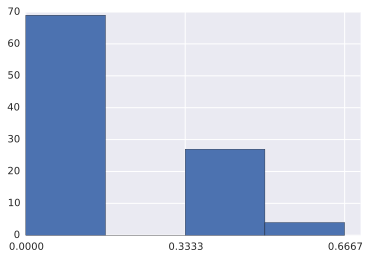

In [19]:
from thesisgenerator.scripts.analysis.signified_internals_analysis import get_replacements_df
from itertools import product

def get_neigh_from_df(df, feature):
    recorded_replacements = []
    for i in range(1, 4):
        r = df.loc[feature]['replacement%d' % i]
        if r:  # remove NaN
            recorded_replacements.append(r)
    return recorded_replacements

try:
    repl1 = get_replacements_df('statistics/stats-exp218-0-cv0-ev.par.csv') # todo hardcoded values, see above
    repl2 = get_replacements_df('statistics/stats-exp225-0-cv0-ev.par.csv')
except FileNotFoundError as e:
    raise ValueError('Cant find file')
assert set(repl1.index) == set(repl2.index)
s = sample(list(repl2.index), 100)
overlap = [dice(get_neigh_from_df(repl1, foo),
                get_neigh_from_df(repl2, foo)) for foo in s]
# print(len(composers), len(reps), len(overlap))
plt.hist(overlap, bins=4);
plt.xticks(np.arange(3)/3);